In [1]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [2]:
import pandas as pd

# Load the datasets
demand_actual = pd.read_csv('demand_actual_qld.csv')
demand_forecast = pd.read_csv('demand_forecast_qld.csv')
interconnections = pd.read_csv('interconnections.csv')
prices_qld = pd.read_csv('prices_qld.csv')
rooftop_solar = pd.read_csv('rooftop_solar_qld.csv')

# Display basic information about each dataset to understand its structure
demand_actual_info = demand_actual.info()
demand_forecast_info = demand_forecast.info()
interconnections_info = interconnections.info()
prices_qld_info = prices_qld.info()
rooftop_solar_info = rooftop_solar.info()

# Display the first few rows of each dataset to get an idea of the data
demand_actual_head = demand_actual.head()
demand_forecast_head = demand_forecast.head()
interconnections_head = interconnections.head()
prices_qld_head = prices_qld.head()
rooftop_solar_head = rooftop_solar.head()

(demand_actual_info, demand_forecast_info, interconnections_info, prices_qld_info, rooftop_solar_info,
 demand_actual_head, demand_forecast_head, interconnections_head, prices_qld_head, rooftop_solar_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44911 entries, 0 to 44910
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date_time           44911 non-null  object
 1   LASTCHANGED         44911 non-null  object
 2   REGIONID            44911 non-null  object
 3   OPERATIONAL_DEMAND  44911 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45313 entries, 0 to 45312
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date_time                 45313 non-null  object 
 1   LASTCHANGED               45313 non-null  object 
 2   REGIONID                  45313 non-null  object 
 3   LOAD_DATE                 45313 non-null  object 
 4   OPERATIONAL_DEMAND_POE10  45313 non-null  float64
 5   OPERATIONAL_DEMAND_POE50  45313 non-null  int64  
 6   O

(None,
 None,
 None,
 None,
 None,
              date_time          LASTCHANGED REGIONID  OPERATIONAL_DEMAND
 0  2022-01-01 00:00:00  2022-01-01 00:00:02     QLD1                6133
 1  2022-01-01 00:30:00  2022-01-01 00:30:01     QLD1                5968
 2  2022-01-01 01:00:00  2022-01-01 01:00:01     QLD1                5877
 3  2022-01-01 01:30:00  2022-01-01 01:30:02     QLD1                5798
 4  2022-01-01 02:00:00  2022-01-01 02:00:01     QLD1                5682,
              date_time          LASTCHANGED REGIONID            LOAD_DATE  \
 0  2022-01-01 00:00:00  2021-12-31 22:57:23     QLD1  2021-12-31 22:57:23   
 1  2022-01-01 00:30:00  2021-12-31 23:57:28     QLD1  2021-12-31 23:57:28   
 2  2022-01-01 01:00:00  2022-01-01 00:27:28     QLD1  2022-01-01 00:27:28   
 3  2022-01-01 01:30:00  2022-01-01 00:57:27     QLD1  2022-01-01 00:57:27   
 4  2022-01-01 02:00:00  2022-01-01 01:27:28     QLD1  2022-01-01 01:27:28   
 
    OPERATIONAL_DEMAND_POE10  OPERATIONAL_DEMAND_P

In [3]:
# Convert the 'date_time' column to datetime in all datasets
demand_actual['date_time'] = pd.to_datetime(demand_actual['date_time'])
demand_forecast['date_time'] = pd.to_datetime(demand_forecast['date_time'])
prices_qld['date_time'] = pd.to_datetime(prices_qld['date_time'])
rooftop_solar['INTERVAL_DATETIME'] = pd.to_datetime(rooftop_solar['INTERVAL_DATETIME'])

# Merge the demand actual, forecast, prices, and rooftop solar data based on date_time
# We'll do a left join starting with demand_actual as the main dataset
merged_data = pd.merge(demand_actual, demand_forecast[['date_time', 'OPERATIONAL_DEMAND_POE50']], 
                       on='date_time', how='left')
merged_data = pd.merge(merged_data, prices_qld[['date_time', 'RRP']], on='date_time', how='left')
merged_data = pd.merge(merged_data, rooftop_solar[['INTERVAL_DATETIME', 'POWER']], 
                       left_on='date_time', right_on='INTERVAL_DATETIME', how='left')

# Drop redundant columns
merged_data.drop(columns=['LASTCHANGED', 'REGIONID', 'INTERVAL_DATETIME'], inplace=True)

# Check the structure of the merged dataset
merged_data.head()


,date_time,OPERATIONAL_DEMAND,OPERATIONAL_DEMAND_POE50,RRP,POWER
0,2022-01-01 00:00:00,6133,6129,118.73,0.0
1,2022-01-01 00:00:00,6133,6129,118.73,0.0
2,2022-01-01 00:30:00,5968,5935,118.73,0.0
3,2022-01-01 00:30:00,5968,5935,118.73,0.0
4,2022-01-01 01:00:00,5877,5886,91.10,0.0


In [4]:
# Feature Engineering: Adding time-based features
merged_data['day_of_week'] = merged_data['date_time'].dt.dayofweek
merged_data['hour'] = merged_data['date_time'].dt.hour

# Lagged Features for better prediction of prices (lag by 1 and 3 intervals)
merged_data['demand_lag_1'] = merged_data['OPERATIONAL_DEMAND'].shift(1)
merged_data['demand_lag_3'] = merged_data['OPERATIONAL_DEMAND'].shift(3)
merged_data['price_lag_1'] = merged_data['RRP'].shift(1)
merged_data['price_lag_3'] = merged_data['RRP'].shift(3)

# Handling missing values created by lagging (just as an example, can be imputed differently)
merged_data.fillna(method='bfill', inplace=True)

# Display the first few rows of the dataset to check new features
merged_data.head()


/var/folders/0t/69p0vkss0r96r21y27qx9pgm0000gn/T/ipykernel_1077/2296404864.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data.fillna(method='bfill', inplace=True)


,date_time,OPERATIONAL_DEMAND,OPERATIONAL_DEMAND_POE50,RRP,POWER,day_of_week,hour,demand_lag_1,demand_lag_3,price_lag_1,price_lag_3
0,2022-01-01 00:00:00,6133,6129,118.73,0.0,5,0,6133.0,6133.0,118.73,118.73
1,2022-01-01 00:00:00,6133,6129,118.73,0.0,5,0,6133.0,6133.0,118.73,118.73
2,2022-01-01 00:30:00,5968,5935,118.73,0.0,5,0,6133.0,6133.0,118.73,118.73
3,2022-01-01 00:30:00,5968,5935,118.73,0.0,5,0,5968.0,6133.0,118.73,118.73
4,2022-01-01 01:00:00,5877,5886,91.10,0.0,5,1,5968.0,6133.0,118.73,118.73


In [5]:
# Features and Target
X = merged_data[['OPERATIONAL_DEMAND', 'OPERATIONAL_DEMAND_POE50', 'POWER', 
                 'day_of_week', 'hour', 'demand_lag_1', 'demand_lag_3', 
                 'price_lag_1', 'price_lag_3']]
y = merged_data['RRP']

# Split data into training and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Show the shape of the datasets to confirm split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((71804, 9), (17951, 9), (71804,), (17951,))

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Perform RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                               n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Best parameters found
rf_random.best_params_

# Predict using the best estimator
y_pred_optimized = rf_random.best_estimator_.predict(X_test)

# Calculate the MAE for the optimized model
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
print(f'Optimized MAE: {mae_optimized}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  41.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  16.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.5min


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  44.6s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.1min
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  44.6s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.1min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  41.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  16.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.6min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  16.0s
[CV] END bootstrap=True, max_depth=30, min_samp

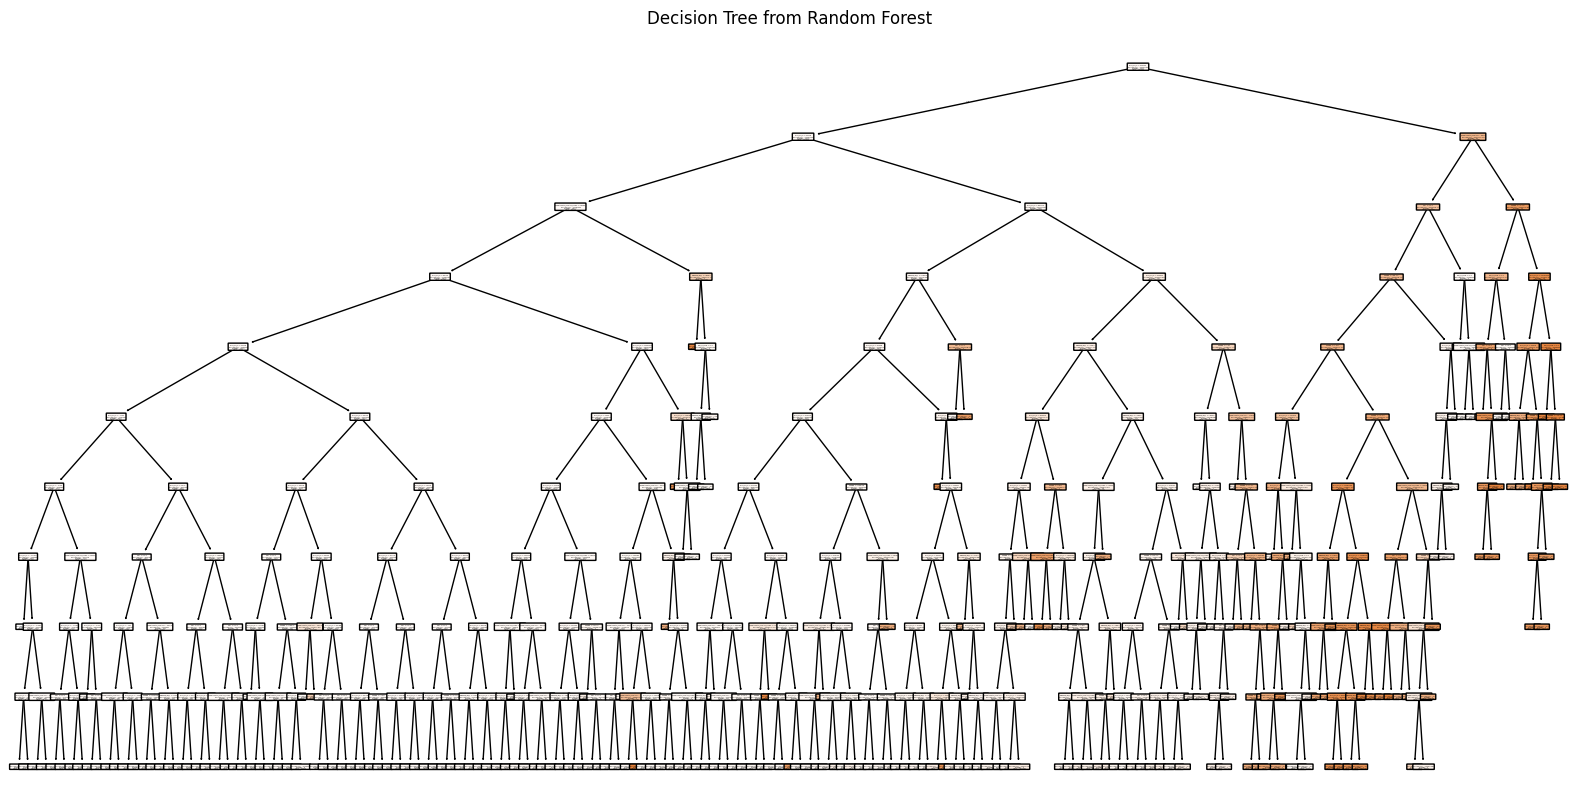

In [7]:
from sklearn.tree import export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt
import graphviz

# Train a Random Forest model with tuned hyperparameters (example)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Extract the first tree from the forest
single_tree = rf_model.estimators_[0]

# Step 1: Visualize the extracted decision tree using plot_tree
plt.figure(figsize=(20, 10))  # Adjust the size based on the complexity of the tree
tree.plot_tree(single_tree, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree from Random Forest")
plt.show()

# # Step 2: Alternatively, export the tree in Graphviz format for detailed visualization
# dot_data = export_graphviz(single_tree, out_file=None, 
#                            feature_names=X.columns,  
#                            filled=True, rounded=True,  
#                            special_characters=True)  
# graph = graphviz.Source(dot_data)  
# graph.render("tree_visualization")  # This will save the tree visualization as a file
# graph

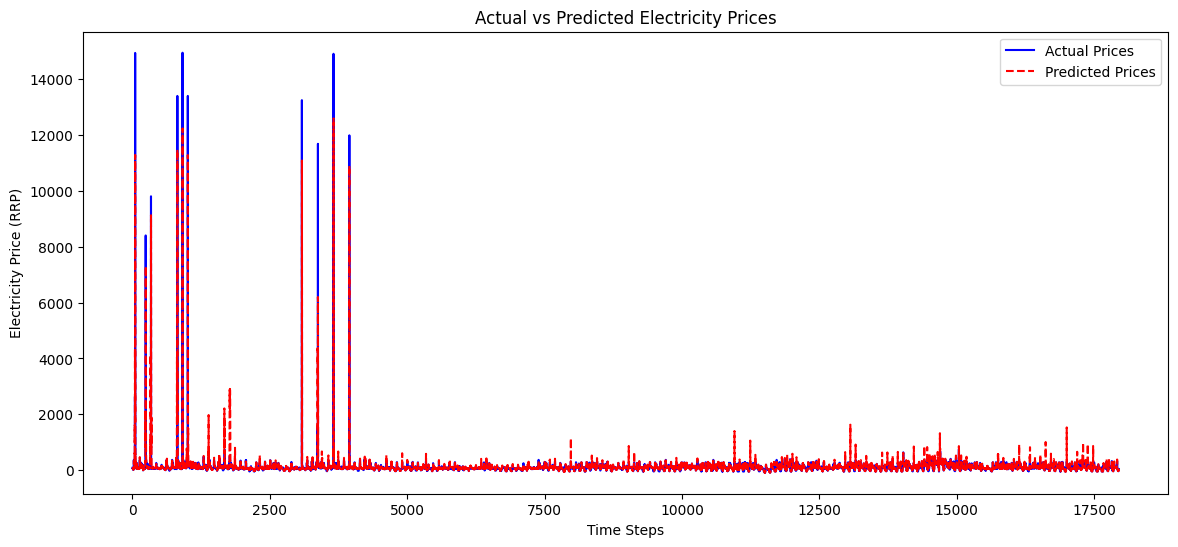

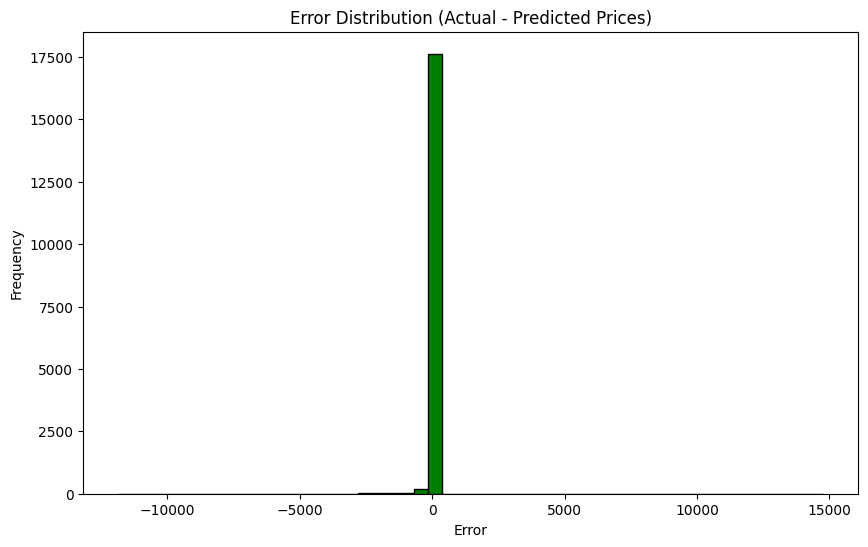

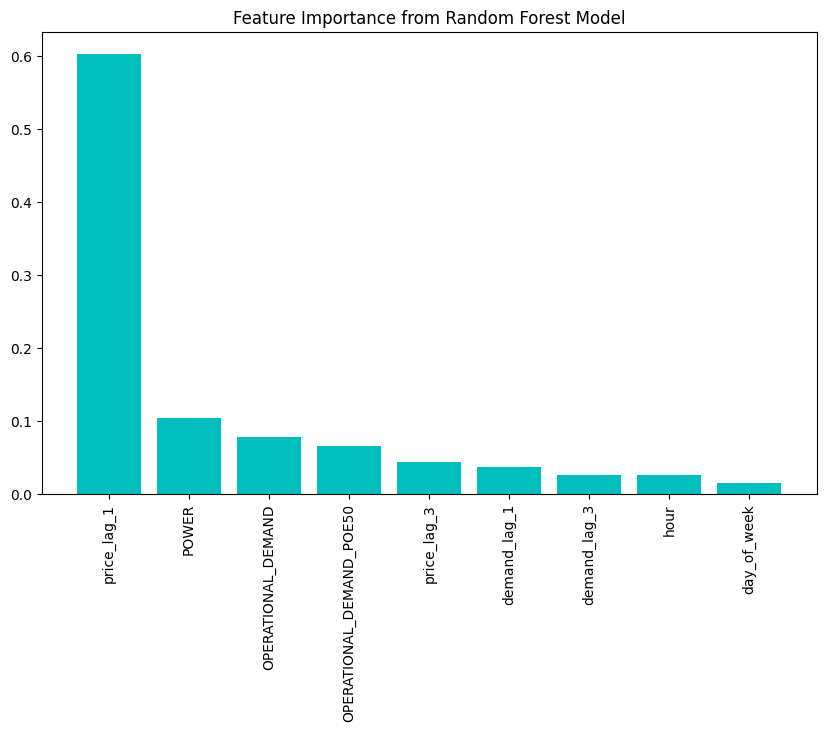

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Plot Actual vs Predicted Prices
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual Prices', color='b')
plt.plot(y_pred_optimized, label='Predicted Prices', color='r', linestyle='--')
plt.title('Actual vs Predicted Electricity Prices')
plt.xlabel('Time Steps')
plt.ylabel('Electricity Price (RRP)')
plt.legend()
plt.show()

# Step 2: Plot Error Distribution
errors = y_test.values - y_pred_optimized
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color='g', edgecolor='black')
plt.title('Error Distribution (Actual - Predicted Prices)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Step 3: Feature Importance Plot
importances = rf_model.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align='center', color='c')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.title('Feature Importance from Random Forest Model')
plt.show()


# Modify

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Perform RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                               n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Best parameters found by RandomizedSearchCV
best_params = rf_random.best_params_
print(f"Best Parameters from RandomizedSearchCV: {best_params}")

# Predict using the best estimator
y_pred_optimized = rf_random.best_estimator_.predict(X_test)

# Calculate the MAE for the optimized model
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
print(f'Optimized MAE: {mae_optimized}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  38.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  14.9s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.4min


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  41.7s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.0min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  41.8s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.0min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  39.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  15.2s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.5min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  15.4s
[CV] END bootstrap=True, max_depth=30, min_samp

In [13]:
import xgboost as xgb

# Initialize XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
xgboost_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgboost_model.predict(X_test)

# Calculate the MAE for the XGBoost model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'MAE from XGBoost: {mae_xgb}')


MAE from XGBoost: 55.570314472955566
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.4min


In [21]:
# Check for NaN values in the predictions
nan_indices = np.isnan(y_pred_lstm_rescaled)
nan_count = np.sum(nan_indices)
print(f'Number of NaNs in LSTM predictions: {nan_count}')


# Forward fill NaNs (propagates last valid value forward)
y_pred_lstm_rescaled_filled = pd.Series(y_pred_lstm_rescaled).fillna(method='ffill').values

# Optionally, use backward fill if necessary
y_pred_lstm_rescaled_filled = pd.Series(y_pred_lstm_rescaled_filled).fillna(method='bfill').values


# Check for NaN values in the predictions
nan_indices = np.isnan(y_pred_lstm_rescaled_filled)
nan_count = np.sum(nan_indices)
print(f'Number of NaNs in LSTM predictions: {nan_count}')

Number of NaNs in LSTM predictions: 1
Number of NaNs in LSTM predictions: 0


/var/folders/0t/69p0vkss0r96r21y27qx9pgm0000gn/T/ipykernel_1077/1768903566.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_pred_lstm_rescaled_filled = pd.Series(y_pred_lstm_rescaled).fillna(method='ffill').values
/var/folders/0t/69p0vkss0r96r21y27qx9pgm0000gn/T/ipykernel_1077/1768903566.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_pred_lstm_rescaled_filled = pd.Series(y_pred_lstm_rescaled_filled).fillna(method='bfill').values


In [23]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Feature scaling (required for LSTMs)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshaping for LSTM [samples, time steps, features]
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))  # Output layer

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32)

# Predict on the test set
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Scale back predictions (inverse scaling)
y_pred_lstm_rescaled = scaler.inverse_transform(np.concatenate((X_test_scaled[:, :-1], y_pred_lstm), axis=1))[:, -1]



Epoch 1/10


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2244/2244 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 249725.9844
Epoch 2/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 236613.8125
Epoch 3/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 272051.4062
Epoch 4/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 304565.5000
Epoch 5/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 239463.8906
Epoch 6/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 213603.2812
Epoch 7/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 227795.0781
Epoch 8/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 237116.5156
Epoch 9/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 242319.4531
Epoch 10/10
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 259447.0625
561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [22]:
# Calculate the MAE for LSTM
mae_lstm = mean_absolute_error(y_test, y_pred_lstm_rescaled_filled)
print(f'MAE from LSTM: {mae_lstm}')

MAE from LSTM: 1758384.9198914259
